In [2]:
import time, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

torch.backends.cudnn.benchmark = True
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

CFG = dict(
    dataset="MNIST",                 # "MNIST" | "FashionMNIST" | "KMNIST"
    seed_list=[2,1,0],
    batch_size=128,
    epochs=50,
    lr=1e-3,
    c=3.5,                           # weight-decay scale: wd = c / n_labelled
    n_init=20,
    n_val=100,
    acq_batch=10,
    rounds=100,                      # 100*10 = 1000 acquired
    pool_subset=2000,
    T_acq=50,
    T_eval=50,
)


DEVICE: cuda


In [3]:
from torchvision.datasets import MNIST, FashionMNIST, KMNIST

_DS = {"MNIST": MNIST, "FashionMNIST": FashionMNIST, "KMNIST": KMNIST}[CFG["dataset"]]

train_raw = _DS(".", train=True, download=True)
test_raw  = _DS(".", train=False, download=True)

X_train_all = train_raw.data.unsqueeze(1).float().div_(255.0)
y_train_all = train_raw.targets.long()
X_test      = test_raw.data.unsqueeze(1).float().div_(255.0)
y_test      = test_raw.targets.long()

m = X_train_all.mean()
s = X_train_all.std().clamp_min(1e-8)
X_train_all = (X_train_all - m) / s
X_test      = (X_test      - m) / s

def balanced_init_indices(y: torch.Tensor, seed: int, n_total: int):
    assert n_total % 10 == 0
    n_per = n_total // 10
    g = torch.Generator().manual_seed(seed)
    out = []
    for c in range(10):
        cand = torch.where(y == c)[0]
        pick = cand[torch.randperm(len(cand), generator=g)[:n_per]]
        out.append(pick)
    idx = torch.cat(out)
    idx = idx[torch.randperm(len(idx), generator=g)]
    return idx

def make_splits(seed: int):
    init_idx = balanced_init_indices(y_train_all, seed, CFG["n_init"])
    mask = torch.ones(len(y_train_all), dtype=torch.bool)
    mask[init_idx] = False
    remaining = torch.where(mask)[0]

    g = torch.Generator().manual_seed(seed + 12345)
    perm = remaining[torch.randperm(len(remaining), generator=g)]
    val_idx  = perm[:CFG["n_val"]]
    pool_idx = perm[CFG["n_val"]:]
    return init_idx, val_idx, pool_idx

ds_test = TensorDataset(X_test, y_test)
init_idx, val_idx, pool_idx = make_splits(0)
print("sizes:", len(init_idx), len(val_idx), len(pool_idx), len(ds_test))
print("init counts:", torch.bincount(y_train_all[init_idx], minlength=10).tolist())


100%|██████████| 9.91M/9.91M [00:00<00:00, 41.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.05MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.67MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.80MB/s]


norm mean/std: 0.13066047430038452 0.30810782313346863
sizes: 20 100 59880 10000
init counts: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [4]:
# ===== Cell 3: model =====
class CNN(nn.Module):
    def __init__(self, dropout=True, p_conv=0.25, p_fc=0.5):
        super().__init__()
        self.dropout = dropout
        self.conv1 = nn.Conv2d(1, 32, 4, 1)
        self.conv2 = nn.Conv2d(32, 32, 4, 1)
        self.pool  = nn.MaxPool2d(2)
        self.dropc = nn.Dropout2d(p_conv)
        self.drop  = nn.Dropout(p_fc)
        self.fc1   = nn.Linear(32 * 11 * 11, 128)
        self.fc2   = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        if self.dropout: x = self.dropc(x)
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        if self.dropout: x = self.drop(x)
        return self.fc2(x)  # logits


# `repeat_interleave` for MC Dropout

Let a minibatch be
$$
x \in \mathbb{R}^{b \times 1 \times 28 \times 28}.
$$

In PyTorch,
xT = x.repeat_interleave(T, dim=0)
produces
$$
x^{(T)} \in \mathbb{R}^{(bT) \times 1 \times 28 \times 28}
$$
by repeating each example \(T\) times along the batch dimension:
$$
x^{(T)}=\big[x_1,\ldots,x_1,\;x_2,\ldots,x_2,\;\ldots,\;x_b,\ldots,x_b\big],
\qquad\text{where each }x_i\text{ appears }T\text{ times.}
$$

With dropout on, one forward pass gives
$$
P = f(x^{(T)}) \in \mathbb{R}^{(bT)\times C}.
$$

Reshape to separate the \(T\) stochastic samples per original example:
$$
P \rightarrow \tilde P \in \mathbb{R}^{T \times b \times C}.
$$

Then the MC mean probability is
$$
\bar p(x_i) = \frac{1}{T}\sum_{t=1}^T \tilde P_{t,i,:}.
$$


In [5]:
# freeze other parameters
def _enable_dropout_only(m):
    for mod in m.modules():
        if isinstance(mod, (nn.Dropout, nn.Dropout2d, nn.Dropout3d)):
            mod.train()

@torch.no_grad()
def predict_proba(model, ds, *, T=0, bs=None):
    """
    T=0: deterministic (dropout off)
    T>0: MC dropout (dropout on, averaged)
    """
    if T <= 0:
        model.eval()
        dl = DataLoader(ds, batch_size=CFG["batch_size"], shuffle=False)
        out = []
        for xb, _ in dl:
            xb = xb.to(DEVICE, non_blocking=True)
            out.append(torch.softmax(model(xb), -1).cpu())
        return torch.cat(out, 0).numpy()

    model.eval()
    _enable_dropout_only(model)
    dl = DataLoader(ds, batch_size=CFG["batch_size"], shuffle=False)
    out = []
    for xb, _ in dl:
        xb = xb.to(DEVICE, non_blocking=True)
        b = xb.size(0)
        xbT = xb.repeat_interleave(T, 0)
        p = torch.softmax(model(xbT), -1)
        p = p.view(b, T, 10).mean(1)
        out.append(p.cpu())
    return torch.cat(out, 0).numpy()

def acc_from_proba(p, y_true):
    y_true = np.asarray(y_true)
    return float((p.argmax(-1) == y_true).mean())


In [6]:

# acquisition scores
def _entropy_t(p, eps=1e-12):
    p = p.clamp_min(eps)
    return -(p * p.log()).sum(-1)

@torch.no_grad()
def mc_scores_subset(model, pool_idx_cur, method, T):
    n = len(pool_idx_cur)
    m = min(CFG["pool_subset"], n)

    sub_local  = np.random.choice(n, size=m, replace=False)
    sub_global = pool_idx_cur[sub_local]

    ds_sub = TensorDataset(X_train_all[sub_global], y_train_all[sub_global])
    dl = DataLoader(ds_sub, batch_size=CFG["batch_size"], shuffle=False)

    model.eval()
    _enable_dropout_only(model)  # dropout ON for scoring

    scores = []
    for xb, _ in dl:
        xb = xb.to(DEVICE, non_blocking=True)
        b = xb.size(0)
        xbT = xb.repeat_interleave(T, 0)
        p = torch.softmax(model(xbT), -1).view(b, T, 10)
        avg = p.mean(1)

        if method == "max_entropy":
            s = _entropy_t(avg)
        elif method == "bald":
            s = _entropy_t(avg) - _entropy_t(p).mean(1)
        elif method == "var_ratios":
            s = 1.0 - avg.max(-1).values
        elif method == "mean_std":
            s = p.std(1, unbiased=False).mean(-1)
        else:
            raise ValueError(method)

        scores.append(s.cpu().numpy())

    return sub_local, np.concatenate(scores, 0)


In [7]:
# optimise only
def make_opt(m, lr, wd):
    decay, nodecay = [], []
    for p in m.parameters():
        if not p.requires_grad:
            continue
        (decay if p.ndim >= 2 else nodecay).append(p)
    return torch.optim.AdamW(
        [{"params": decay, "weight_decay": wd},
         {"params": nodecay, "weight_decay": 0.0}],
        lr=lr,
    )


In [8]:
def fit_from_scratch(cnn_mode, X, y, seed, *, c=None, lr=None, epochs=None):
    set_seed(seed)
    m = CNN(dropout=(cnn_mode == "mc")).to(DEVICE).train()

    c = 3.5
    wd = c / len(X) if c is not None else 0.0
    lr = CFG["lr"] #if lr is None else lr
    opt = make_opt(m, lr, wd)

    ds = TensorDataset(X, y)
    dl = DataLoader(
        ds,
        batch_size=CFG["batch_size"],#min(CFG["batch_size"], len(ds)),
        shuffle=True,
        drop_last=False,
    )


    E = CFG["epochs"] if epochs is None else epochs
    for _ in range(E):
        for xb, yb in dl:
            xb = xb.to(DEVICE, non_blocking=True)
            yb = yb.to(DEVICE, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            loss = F.cross_entropy(m(xb), yb)
            loss.backward()
            opt.step()
    return m

In [17]:
def run_active_learning(seed, method, *, cnn_mode="mc", eval_mode="mc", verbose=True):
    """
    cnn_mode: "mc" => dropout in model (Bayesian CNN)
              "det" => no dropout (deterministic CNN)

    eval_mode: "mc" => MC dropout test eval (only meaningful for cnn_mode="mc")
              "det" => single forward pass (dropout off)
    """
    set_seed(seed)
    init_idx, val_idx, pool_idx = make_splits(seed)

    val_ds = TensorDataset(X_train_all[val_idx], y_train_all[val_idx])
    labelled_idx = init_idx.clone()
    pool_idx_cur = pool_idx.cpu().numpy().copy()

    x_axis = [0]
    accs = []

    def eval_test(m):
        T = CFG["T_eval"] if (eval_mode == "mc" and cnn_mode == "mc") else 0
        p = predict_proba(m, ds_test, T=T)
        return acc_from_proba(p, y_test.cpu().numpy())

    def eval_val_det(m):
        p = predict_proba(m, val_ds, T=0)
        return acc_from_proba(p, val_ds.tensors[1].cpu().numpy())

    # initial train
    m = fit_from_scratch(cnn_mode, X_train_all[labelled_idx], y_train_all[labelled_idx], seed=seed)
    accs.append(eval_test(m))
    if verbose:
        print(f"[{method}][{cnn_mode}][eval={eval_mode}] x=0 val={eval_val_det(m)*100:.2f}% test={accs[-1]*100:.2f}%")

    t0 = time.time()
    for r in range(1, CFG["rounds"] + 1):
        n = len(pool_idx_cur)
        # deterministc bald collapses into random acquisition
        if method == "random" or (cnn_mode == "det" and method == "bald"):
            chosen_local = np.random.choice(n, CFG["acq_batch"], replace=False)

        else:
            sub_local, score = mc_scores_subset(m, pool_idx_cur, method, T=CFG["batch_size"] if cnn_mode=="mc" else 1)
            chosen_in_sub = np.argsort(-score)[:CFG["acq_batch"]]
            chosen_local = sub_local[chosen_in_sub]

        newly = pool_idx_cur[chosen_local]
        labelled_idx = torch.cat([labelled_idx, torch.from_numpy(newly).long()])

        keep = np.ones(n, dtype=bool)
        keep[chosen_local] = False
        pool_idx_cur = pool_idx_cur[keep]

        m = fit_from_scratch(cnn_mode, X_train_all[labelled_idx], y_train_all[labelled_idx], seed=seed + r)
        accs.append(eval_test(m))
        x_axis.append(r * CFG["acq_batch"])

        if verbose:
            el = time.time() - t0
            eta = (el / r) * (CFG["rounds"] - r)
            print(f"r={r:3d}/{CFG['rounds']} x={x_axis[-1]:4d} val={eval_val_det(m)*100:5.2f}% "
                  f"test={accs[-1]*100:5.2f}% ETA={eta/60:5.1f}m")

    return np.array(x_axis), np.array(accs)


In [13]:
METHODS_51 = ["bald", "var_ratios", "max_entropy", "mean_std", "random"]

def exp_51(*, eval_mode="mc", cnn_mode="mc", verbose=True):
    all_runs = {}
    t0 = time.time()
    total = len(METHODS_51) * len(CFG["seed_list"])
    done = 0

    for mth in METHODS_51:
        runs = []
        for s in CFG["seed_list"]:
            done += 1
            if verbose:
                el = time.time() - t0
                eta = (el / max(done, 1)) * (total - done)
                print(f"\n=== [{done}/{total}] method={mth} seed={s} cnn={cnn_mode} eval={eval_mode} ETA={eta/60:.1f}m ===")
            x, acc = run_active_learning(s, mth, eval_mode=eval_mode, cnn_mode=cnn_mode, verbose=verbose)
            runs.append(acc)
        all_runs[mth] = np.stack(runs, 0)
    return x, all_runs


In [14]:
_COL = {
    "bald":       "#4C78A8",
    "var_ratios": "#F58518",
    "max_entropy":"#54A24B",
    "mean_std":   "#B279A2",
    "random":     "#9D9DA3",
}
_LAB = {"bald":"BALD","var_ratios":"Var Ratios","max_entropy":"Max Entropy","mean_std":"Mean STD","random":"Random"}

def plot_runs(x, all_runs):
    order = ["bald", "var_ratios", "max_entropy", "mean_std", "random"]
    x = x / 100.0

    fig, ax = plt.subplots(figsize=(6.8, 4.6), dpi=160)

    for m in order:
        mu = 100.0 * all_runs[m].mean(0)   # assumes runs are in [0,1]
        ax.plot(x, mu, lw=2.8, color=_COL[m], solid_capstyle="round")

    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(80, 100)
    ax.set_yticks(np.arange(80, 100.1, 2))
    ax.set_xticks(np.arange(np.floor(x.min()), np.ceil(x.max()) + 1, 1))

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.grid(True, linestyle="--", linewidth=1.0, alpha=0.35)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    for s in ["left", "bottom"]:
        ax.spines[s].set_linewidth(1.2)
        ax.spines[s].set_color("black")

    ax.tick_params(axis="both", which="both", length=4, width=1, color="black")

    leg = ax.legend([_LAB[m] for m in order], loc="lower right",
                    frameon=True, fancybox=False, framealpha=1,
                    edgecolor="black")
    leg.get_frame().set_linewidth(1.2)

    fig.tight_layout()
    plt.show()

def crossing_images(x, acc, target_acc):
    w = np.where(acc >= target_acc)[0]
    return float(x[w[0]]) if len(w) else float("nan")

def crossing_table(x, all_runs, targets=(0.90, 0.95)):
    rows = []
    for m in METHODS_51:
        row = {"method": m}
        for t in targets:
            xs = [crossing_images(x, all_runs[m][i], t) for i in range(all_runs[m].shape[0])]
            row[f"avg images to {int(100*t)}%"] = np.nanmean(xs)
            row[f"std images to {int(100*t)}%"] = np.nanstd(xs)
        rows.append(row)
    return pd.DataFrame(rows)



=== [1/15] method=bald seed=2 cnn=mc eval=mc ETA=0.0m ===
[bald][mc][eval=mc] x=0 val=51.00% test=53.71%
r=  1/100 x=  10 val=56.00% test=60.01% ETA=  1.9m
r=  2/100 x=  20 val=63.00% test=60.81% ETA=  1.9m
r=  3/100 x=  30 val=56.00% test=64.83% ETA=  1.9m
r=  4/100 x=  40 val=61.00% test=68.96% ETA=  1.9m
r=  5/100 x=  50 val=65.00% test=75.04% ETA=  1.8m
r=  6/100 x=  60 val=65.00% test=74.70% ETA=  1.8m
r=  7/100 x=  70 val=72.00% test=77.31% ETA=  1.8m
r=  8/100 x=  80 val=70.00% test=78.95% ETA=  1.8m
r=  9/100 x=  90 val=68.00% test=76.34% ETA=  1.8m
r= 10/100 x= 100 val=73.00% test=77.93% ETA=  1.8m
r= 11/100 x= 110 val=68.00% test=80.60% ETA=  1.8m
r= 12/100 x= 120 val=77.00% test=83.88% ETA=  1.8m
r= 13/100 x= 130 val=79.00% test=84.39% ETA=  1.7m
r= 14/100 x= 140 val=85.00% test=88.83% ETA=  1.7m
r= 15/100 x= 150 val=84.00% test=89.66% ETA=  1.7m
r= 16/100 x= 160 val=87.00% test=90.27% ETA=  1.7m
r= 17/100 x= 170 val=90.00% test=90.40% ETA=  1.7m
r= 18/100 x= 180 val=87.00%

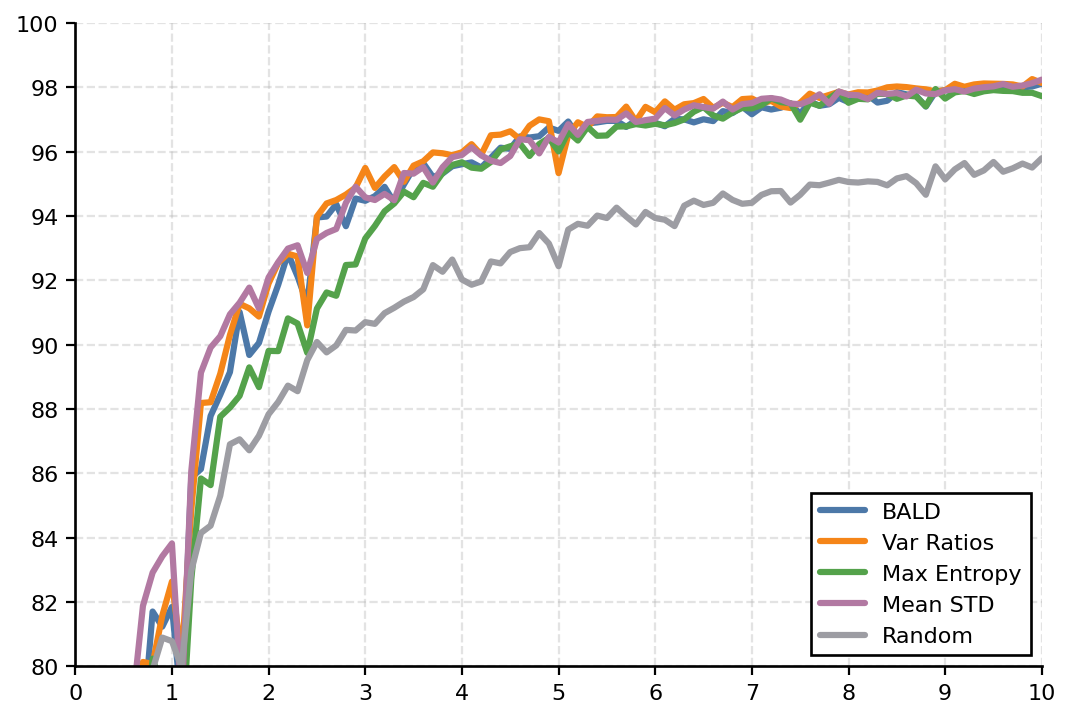

,method,avg images to 90%,std images to 90%,avg images to 95%,std images to 95%
0,bald,166.666667,4.714045,316.666667,4.714045
1,var_ratios,160.000000,8.164966,286.666667,12.472191
2,max_entropy,196.666667,12.472191,343.333333,12.472191
3,mean_std,146.666667,9.428090,313.333333,26.246693
4,random,256.666667,16.996732,740.000000,63.770422


In [15]:

# experiment 5.1
x_mc, all_mc = exp_51(eval_mode="mc", cnn_mode="mc", verbose=True)
plot_runs(x_mc, all_mc)
display(crossing_table(x_mc, all_mc))


In [18]:
# ===== compare Det vs Bayesian CNN, eval Bayesian deterministically =====
METHODS_52 = ["bald", "var_ratios", "max_entropy"]

def exp_52(methods=METHODS_52, *, verbose=True):
    out = {m: {"det": [], "bayes": []} for m in methods}
    for mth in methods:
        for s in CFG["seed_list"]:
            if verbose: print(f"\n[Exp5.2] method={mth} seed={s} (det)")
            x, acc_det = run_active_learning(s, mth, cnn_mode="det", eval_mode="det", verbose=verbose)
            out[mth]["det"].append(acc_det)

            if verbose: print(f"\n[Exp5.2] method={mth} seed={s} (bayes, eval det)")
            x, acc_b = run_active_learning(s, mth, cnn_mode="mc", eval_mode="det", verbose=verbose)
            out[mth]["bayes"].append(acc_b)

        out[mth]["det"]   = np.stack(out[mth]["det"], 0)
        out[mth]["bayes"] = np.stack(out[mth]["bayes"], 0)
    return x, out


In [19]:
import numpy as np
import matplotlib.pyplot as plt

def plot_52(x, out_52):
    x = x / 100.0
    order = METHODS_52

    fig, axs = plt.subplots(1, 3, figsize=(14.2, 4.2), dpi=160, sharey=True)

    for ax, mth in zip(axs, order):
        mu_det = 100.0 * out_52[mth]["det"].mean(0)
        mu_b   = 100.0 * out_52[mth]["bayes"].mean(0)

        ax.plot(x, mu_det, lw=2.8, label="Det CNN")
        ax.plot(x, mu_b,   lw=2.8, label="Bayesian CNN (eval det)")

        ax.set_title(_LAB[mth])
        ax.set_xlim(x.min(), x.max())
        ax.set_ylim(80, 100)
        ax.set_yticks(np.arange(80, 100.1, 2))
        ax.set_xticks(np.arange(np.floor(x.min()), np.ceil(x.max()) + 1, 1))

        ax.grid(True, linestyle="--", linewidth=1.0, alpha=0.35)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        for s in ["left", "bottom"]:
            ax.spines[s].set_linewidth(1.2)
            ax.spines[s].set_color("black")

        ax.tick_params(axis="both", which="both", length=4, width=1, color="black")
        ax.set_xlabel("")
        ax.set_ylabel("")

    leg = axs[0].legend(loc="lower right", frameon=True, fancybox=False,
                        framealpha=1, edgecolor="black")
    leg.get_frame().set_linewidth(1.2)

    fig.tight_layout()
    plt.show()



[Exp5.2] method=bald seed=2 (det)
[bald][det][eval=det] x=0 val=55.00% test=54.26%
r=  1/100 x=  10 val=57.00% test=53.75% ETA=  0.4m
r=  2/100 x=  20 val=59.00% test=61.61% ETA=  0.4m
r=  3/100 x=  30 val=65.00% test=67.49% ETA=  0.4m
r=  4/100 x=  40 val=67.00% test=69.90% ETA=  0.4m
r=  5/100 x=  50 val=68.00% test=73.20% ETA=  0.4m
r=  6/100 x=  60 val=70.00% test=73.43% ETA=  0.4m
r=  7/100 x=  70 val=76.00% test=75.81% ETA=  0.4m
r=  8/100 x=  80 val=76.00% test=75.77% ETA=  0.4m
r=  9/100 x=  90 val=74.00% test=75.98% ETA=  0.4m
r= 10/100 x= 100 val=73.00% test=76.32% ETA=  0.4m
r= 11/100 x= 110 val=78.00% test=79.04% ETA=  0.4m
r= 12/100 x= 120 val=76.00% test=79.78% ETA=  0.4m
r= 13/100 x= 130 val=78.00% test=81.30% ETA=  0.5m
r= 14/100 x= 140 val=77.00% test=83.56% ETA=  0.5m
r= 15/100 x= 150 val=80.00% test=84.93% ETA=  0.5m
r= 16/100 x= 160 val=81.00% test=84.17% ETA=  0.5m
r= 17/100 x= 170 val=80.00% test=84.79% ETA=  0.5m
r= 18/100 x= 180 val=79.00% test=83.67% ETA=  0.5

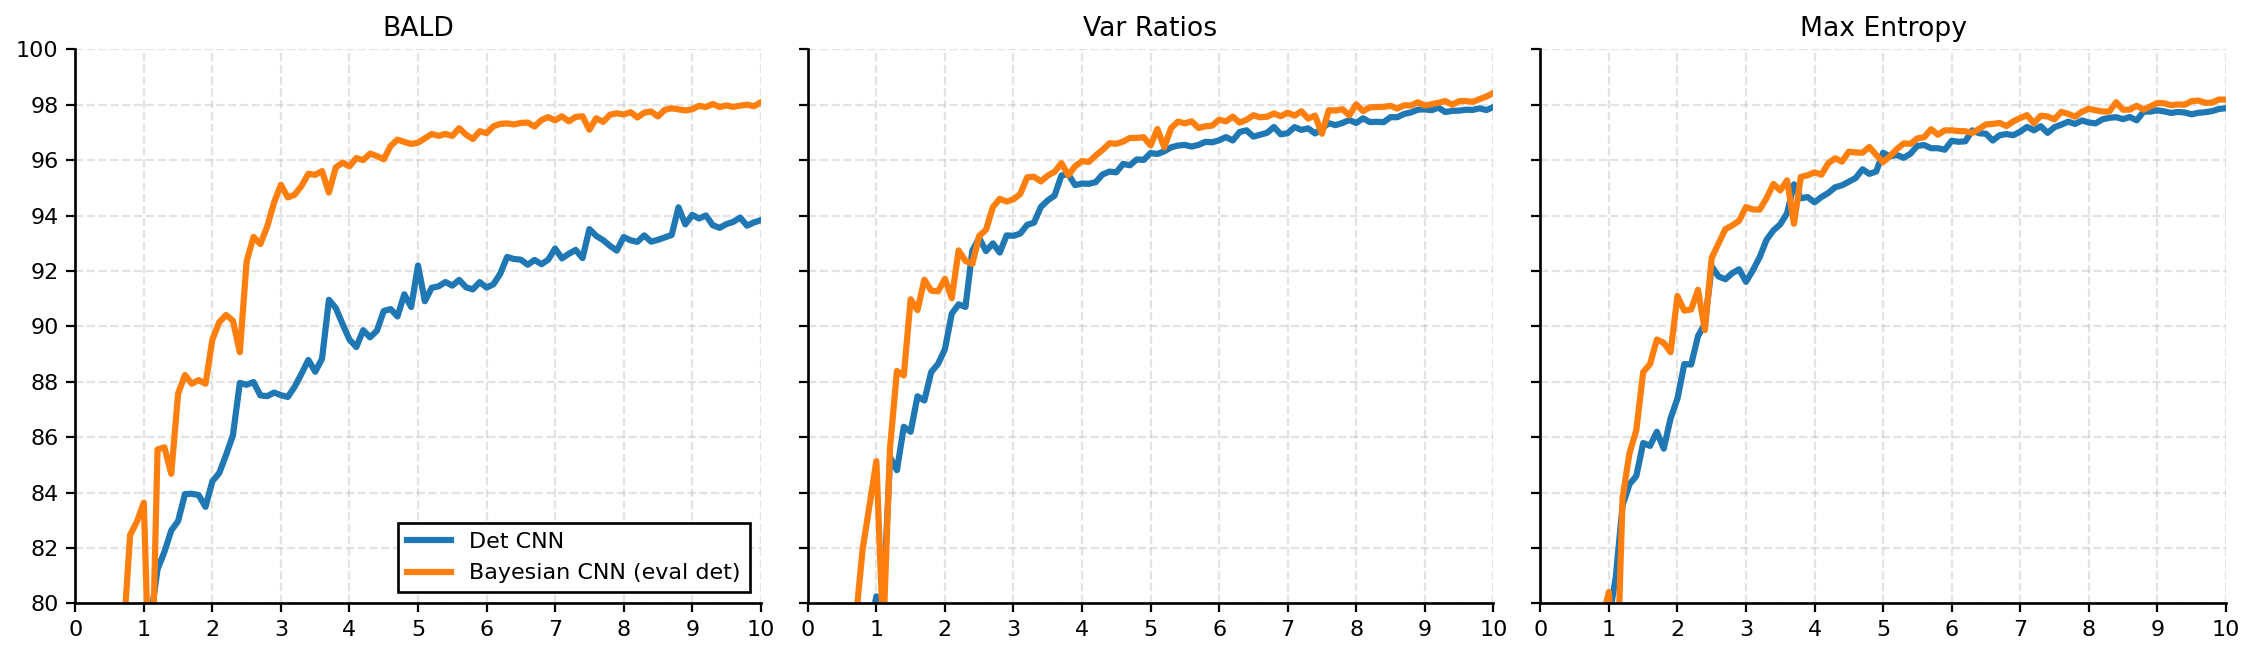

In [21]:
#experiment 5.2
_COL = {
    "bald":       "#4C78A8",
    "var_ratios": "#F58518",
    "max_entropy":"#54A24B",
    "mean_std":   "#B279A2",
    "random":     "#9D9DA3",
}

_LAB = {
    "bald": "BALD",
    "var_ratios": "Var Ratios",
    "max_entropy": "Max Entropy",
    "mean_std": "Mean STD",
    "random": "Random",
}

x_52, out_52 = exp_52(verbose=True)
plot_52(x_52, out_52)